# 初期設定

In [2]:
#サンプルサイズ
N = 10**3

#共変量の次元数
K = 4
cov_list_str = ["X1", "X2", "X3", "X4"]

#一様分布の範囲
a, b = [-1, 0]

#カーネル回帰のテストデータの割合
size = 0.25

# import

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


#傾向スコアの推定
from sklearn.linear_model import LogisticRegression

#カーネル回帰
from sklearn.kernel_ridge import KernelRidge
#モデルの評価
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split

import itertools

# 汎用関数

In [4]:
#真の傾向スコアモデル
def propensity_score(vec, coef = np.array([-1, -1, -1, -1])):
    linear = vec*coef
    return(1/(1+np.exp(np.sum(linear))))

#真の結果変数
def result(vec, coef = np.array([1, 2, 3, 4, 1])):
    linear = vec*coef
    return(np.sum(linear))

# シミュレーションデータの発生

In [5]:
#シミュレーションデータ生成
df = pd.DataFrame((b-a)*np.random.rand(N,K)+a, columns = cov_list_str)

#真の傾向スコアの計算
true_propensity_score = pd.DataFrame(df.apply(propensity_score, axis=1), columns = ["true_propensity_score"])

#真の傾向スコアをもとのデータフレームにマージ
df_true_ps = pd.merge(df, true_propensity_score, how="left", left_index=True, right_index=True)

#真の傾向スコアに基づき介入変数を乱数で発生させる
treatment = pd.DataFrame([np.random.binomial(n=1, p=p) for p in true_propensity_score["true_propensity_score"]], columns = ["treatment_flg"])

#介入変数をもとのデータフレームにマージ
df_treatment = pd.merge(df_true_ps, treatment, how="left", left_index=True, right_index=True)

#結果変数を計算
Y = df_treatment[cov_list_str+["treatment_flg"]].apply(result, axis=1)
result_col = pd.DataFrame(Y, columns = ["result"])

#結果変数をもとのデータフレームにマージ
df_result = pd.merge(df_treatment, result_col, how="left", left_index=True, right_index=True)

In [6]:
df_treatment

,X1,X2,X3,X4,true_propensity_score,treatment_flg
0,-0.406945,-0.886709,-0.747876,-0.854270,0.052362,1
1,-0.866911,-0.968752,-0.738895,-0.161085,0.060903,0
2,-0.805324,-0.340955,-0.018810,-0.784663,0.124580,0
3,-0.825400,-0.178573,-0.699425,-0.087243,0.142994,1
4,-0.404788,-0.011045,-0.162012,-0.064039,0.344821,0
...,...,...,...,...,...,...
995,-0.275407,-0.698214,-0.720999,-0.924032,0.067948,0
996,-0.247898,-0.808228,-0.496378,-0.080989,0.163352,0
997,-0.355019,-0.961516,-0.296794,-0.874116,0.076743,0
998,-0.444870,-0.078333,-0.193144,-0.441820,0.239000,0


## シミュレーションデータの確認

In [7]:
#単純に介入の有無で結果変数の平均をとったもの
simple_result0 = df_result.groupby("treatment_flg").mean()["result"][0]
simple_result1 = df_result.groupby("treatment_flg").mean()["result"][1]

#RCT
##RCTで介入変数を決める
RCT_treatment = pd.DataFrame(np.random.binomial(n=1, p=1/2, size=N), columns = ["RCT_treatment_flg"])
##RCTの介入変数をもとのデータフレームにマージ
RCT = pd.merge(df_result, RCT_treatment, how="left", left_index=True, right_index=True)

##RCTの場合の結果変数
RCT_Y = 1*RCT[cov_list_str[0]]+2*RCT[cov_list_str[1]]+3*RCT[cov_list_str[2]]+4*RCT[cov_list_str[3]]+RCT["RCT_treatment_flg"]
RCT_Y_df = pd.DataFrame(RCT_Y, columns = ["RCT_result"])
RCT_result = pd.merge(RCT, RCT_Y_df,  how="left", left_index=True, right_index=True)


##RCTで結果変数の平均をとったもの
rct_result0 = RCT_result.groupby("RCT_treatment_flg").mean()["RCT_result"][0]
rct_result1 = RCT_result.groupby("RCT_treatment_flg").mean()["RCT_result"][1]

#指標のprint
print("介入なしの結果変数の平均：", simple_result0)
print("介入ありの結果変数の平均：", simple_result1)
print("RCTの介入なしの結果変数の平均：", rct_result0)
print("RCTの介入ありの結果変数の平均：", rct_result1)
print("セレクションバイアスが含まれた効果：", simple_result1-simple_result0)
print("RCTによる効果(真に近い効果)：", rct_result1-rct_result0)
print("セレクションバイアス：", (simple_result1-simple_result0)-(rct_result1-rct_result0))

介入なしの結果変数の平均： -5.102475784838602
介入ありの結果変数の平均： -3.362923832200133
RCTの介入なしの結果変数の平均： -5.013860692133069
RCTの介入ありの結果変数の平均： -3.992848930714201
セレクションバイアスが含まれた効果： 1.739551952638469
RCTによる効果(真に近い効果)： 1.021011761418868
セレクションバイアス： 0.718540191219601


# 傾向スコアの推定
GMMのpythonパッケージ
statsmodels.sandbox.regression.gmm.GMM

## ロジスティック回帰モデル

In [8]:
#ロジスティック回帰モデルのインスタンス作成
lr = LogisticRegression()

#ロジスティック回帰モデルの推定
lr.fit(df_result[cov_list_str], df_result["treatment_flg"])

#推定された傾向スコア
est_propensity_score = lr.predict_proba(df_result[cov_list_str])[:,1]

#傾向スコアをもとのデータフレームにマージ
df_estps = (
    pd.merge(
        df_result,
        pd.DataFrame(est_propensity_score, columns = ["est_propensity_score"]),
        how="left",
        left_index=True,
        right_index=True)
)

# 共変量調整

## 傾向スコアマッチング

In [9]:
#傾向スコアマッチング(最近傍マッチング)を実行するクラス
class propensityScoreMatching:
    #__init_で傾向スコアマッチングを行い、indexの組み合わせを取得する
    def __init__(self, df, cov_list, z, ps, rs):
        self.df = df
        self.cov_list = cov_list
        self.z = z
        self.ps = ps
        self.rs = rs
        
        
        #介入の有無でデータフレームを分割
        self.df0 = self.df[self.df[z] == 0]
        self.df1 = self.df[self.df[z] == 1]
        
        #df0のindex取得
        tmp_df0_index = self.df0[self.ps].index.values
        #マッチング後のindexを入れる変数を定義(介入なし)
        self.df0_index = np.empty(0, dtype="int64")
        #マッチング後のindexを定義(介入あり)
        self.df1_index = self.df1[self.ps].index.values
        
        #最近傍マッチングで傾向スコアマッチング
        for eps1 in self.df1[self.ps]:
            #介入ありと介入なしの傾向スコアの差の絶対値を計算
            abs_eps_list = [abs(eps1-eps0) for eps0 in self.df0[self.ps]]
            #傾向スコアの差の絶対値が最小のindexを取得
            min_index = tmp_df0_index[abs_eps_list.index(min(abs_eps_list))]
            #マッチング後のindexを入れる
            self.df0_index = np.append(self.df0_index, min_index)
            
    def get_effect(self):
        #各群の結果変数の平均を取得
        self.mean0 = np.average(self.df0.loc[self.df0_index][self.rs])  
        self.mean1 = np.average(self.df1.loc[self.df1_index][self.rs])
        
        return (self.mean1-self.mean0)
        
    def compare_cov_mean_var(self):
        #共変量調整後の共変量の平均
        self.cov_mean0 = np.mean(self.df0[self.cov_list].loc[self.df0_index])
        self.cov_mean1 = np.mean(self.df1[self.cov_list].loc[self.df1_index])
        
        #共変量調整後の共変量の分散
        self.cov_var0 = np.var(self.df0[self.cov_list].loc[self.df0_index])
        self.cov_var1 = np.var(self.df1[self.cov_list].loc[self.df1_index])
             
        #共変量調整前の共変量の平均
        self.not_cov_mean0 = np.mean(self.df0[self.cov_list])
        self.not_cov_mean1 = np.mean(self.df1[self.cov_list])
        
        #共変量調整前の共変量の分散
        self.not_cov_var0 = np.var(self.df0[self.cov_list])
        self.not_cov_var1 = np.var(self.df1[self.cov_list])
        
        #共変量調整後の共変量の平均の差
        self.adjusted_abs_diff_mean = abs(self.cov_mean1-self.cov_mean0)
        
        #共変量調整後の共変量の分散の差
        self.adjusted_abs_diff_var = abs(self.cov_var1-self.cov_var0)
        
        #共変量調整前の共変量の平均の差
        self.not_adjusted_abs_diff_mean = abs(self.not_cov_mean1-self.not_cov_mean0)
        
        #共変量調整前の共変量の分散の差
        self.not_adjusted_abs_diff_var = abs(self.not_cov_var1-self.not_cov_var0)
        
        
        #作図
        ##パラメータ
        top = np.arange(len(self.adjusted_abs_diff_mean))
        height = 0.3
        ##作図関数
        #plt.subplot(1, 2, 1)
        plt.barh(top, self.adjusted_abs_diff_mean, label="adjusted", height=0.3, align="edge", zorder=10) 
        plt.barh(top+height, self.not_adjusted_abs_diff_mean, label="not adjusted", height=0.3, align="edge", zorder=10) 
        plt.yticks(top+height, self.adjusted_abs_diff_mean.index)
        plt.vlines([0.1], ymin=0, ymax=len(self.adjusted_abs_diff_mean), linestyle = "dashed")
        plt.ylim(0, len(self.adjusted_abs_diff_mean))
        plt.xlabel("Absolute Mean Differences")
        plt.ylabel("Covariate Balance")
        plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0, fontsize=8)
        
        ##作図関数(分散まではあまり見られていないので一旦省略)
        #plt.subplot(1, 2, 2)
        #plt.barh(top, self.adjusted_abs_diff_var, label="adjusted", height=0.3, align="edge", zorder=10) 
        #plt.barh(top+height, self.not_adjusted_abs_diff_var, label="not adjusted", height=0.3, align="edge", zorder=10) 
        #plt.yticks(color="None")
        #plt.vlines([0.1], ymin=0, ymax=len(self.adjusted_abs_diff_var), linestyle = "dashed")
        #plt.ylim(0, len(self.adjusted_abs_diff_var))
        #plt.xlabel("Absolute Variance Differences")
        #plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0, fontsize=8)
        
    #def compare_cov_graph(self):

In [10]:
match_result = (
    propensityScoreMatching(
        df = df_estps,
        cov_list = cov_list_str,
        z = "treatment_flg",
        ps = "est_propensity_score",
        rs = "result")
)

In [11]:
match_result.get_effect()

1.0150372541122654

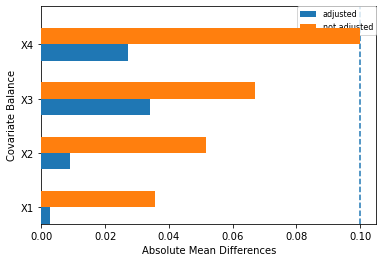

In [12]:
match_result.compare_cov_mean_var()

## IPW推定

In [13]:
#IPW推定量によって効果を算出するクラス
class inverseProbbilityWeight:
    #__init_でIPWを算出する
    def __init__(self, df, cov_list, z, ps, rs):
        self.df = df
        self.cov_list = cov_list
        self.z = z
        self.ps = ps
        self.rs = rs
        
        #介入の有無でデータフレームを分割
        self.df0 = self.df[self.df[z] == 0]
        self.df1 = self.df[self.df[z] == 1]
        
    def ipw(self, column):
        ipw1 = np.sum((self.df1[self.z]*self.df1[column])/self.df1[self.ps])/np.sum(self.df1[self.z]/self.df1[self.ps])
        ipw0 = np.sum(((1-self.df0[self.z])*self.df0[column])/(1-self.df0[self.ps]))/np.sum((1-self.df0[self.z])/(1-self.df0[self.ps]))       
        
        return(ipw1, ipw0)
    
    def get_effect(self):
        #各群のIPW推定量を計算
        self.ipw_mean1, self.ipw_mean0 = self.ipw(column=self.rs)
               
        return (self.ipw_mean1-self.ipw_mean0)
        
    def compare_cov_mean_var(self):
        #共変量調整後の共変量の平均の差の絶対値
        ipw_list = [self.ipw(cov) for cov in self.cov_list]
        self.adjusted_abs_diff_mean = [abs(ipw1-ipw0) for ipw1, ipw0 in ipw_list]
        
        #共変量調整前の共変量の平均の差の絶対値          
        ##共変量調整前の共変量の平均
        self.not_cov_mean0 = np.mean(self.df0[self.cov_list])
        self.not_cov_mean1 = np.mean(self.df1[self.cov_list])
        ##差の絶対値
        self.not_adjusted_abs_diff_mean = abs(self.not_cov_mean1-self.not_cov_mean0)
        
        #共変量調整前の共変量の分散の差
        self.not_adjusted_abs_diff_mean = abs(self.not_cov_mean1-self.not_cov_mean0)
        
        #作図
        ##パラメータ
        top = np.arange(len(self.adjusted_abs_diff_mean))
        height = 0.3
        ##作図関数
        #plt.subplot(1, 2, 1)
        plt.barh(top, self.adjusted_abs_diff_mean, label="adjusted", height=0.3, align="edge", zorder=10) 
        plt.barh(top+height, self.not_adjusted_abs_diff_mean, label="not adjusted", height=0.3, align="edge", zorder=10) 
        plt.yticks(top+height, self.cov_list)
        plt.vlines([0.1], ymin=0, ymax=len(self.adjusted_abs_diff_mean), linestyle = "dashed")
        plt.ylim(0, len(self.adjusted_abs_diff_mean))
        plt.xlabel("Absolute Mean Differences")
        plt.ylabel("Covariate Balance")
        plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0, fontsize=8)

In [14]:
ipw_result = (
    inverseProbbilityWeight(
        df = df_estps,
        cov_list = cov_list_str,
        z = "treatment_flg",
        ps = "est_propensity_score",
        rs = "result")
)

In [15]:
ipw_result.get_effect()

1.073807928862308

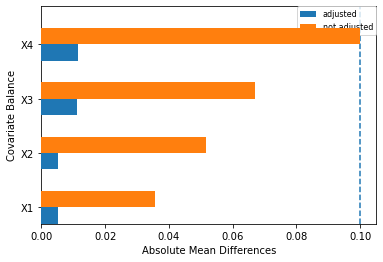

In [16]:
ipw_result.compare_cov_mean_var()

## カーネル回帰

In [17]:
#介入群と非介入群に分割する
df_estps1 = df_estps[df_estps["treatment_flg"] == 1]
df_estps0 = df_estps[df_estps["treatment_flg"] == 0]

In [18]:
df_estps0_train, df_estps0_test = train_test_split(df_estps0, test_size = size)

## カーネルの定義

In [19]:
## ガウシアンカーネル
def gaussianKernel(x, x_prime, width):
    k = np.exp(- np.linalg.norm(x - x_prime)**2 / (2 * width**2))
    return(k)

##イパネクニコフ2次カーネル
def epanechinikovKernel(x, x_prime, width):
    t = abs(x-x_prime)/width
    D = 3/4*(1-t**2) if abs(t) <= 1 else 0
    return(D)

## p次カーネル回帰

In [20]:
def localRegression(x, resvar, exvar, treatvar, df, kernel = "gaussianKernel", width = 0.1, dim = 1):
    
    #説明変数の行列作成
    X = np.ones(len(df[exvar]))
    for p in range(1, dim+1):
        xp = df[exvar]**p
        X = np.c_[X, xp]
        
    #カーネルが入った対角行列作成
    if kernel == "gaussianKernel":
        kernel_list = [(1-z_ele)*gaussianKernel(x, x_ele, width) for x_ele, z_ele in zip(df[exvar], df[treatvar])]
    elif kernel == "epanechinikovKernel":
        kernel_list = [(1-z_ele)*epanechinikovKernel(x, x_ele, width) for x_ele, z_ele in zip(df[exvar], df[treatvar])]
    else:
        print("please input kernel")
        return()
    
    W = np.diag(kernel_list)
       
    coef = np.linalg.inv((X.T)@W@X)@(X.T)@W@df[resvar]
    predict = np.sum(coef*[x**p for p in range(0, dim+1)])
    return(predict)

In [21]:
#対照群の訓練データを用いたモデルの作成とテストデータを用いた汎化性能の測定
##パラメータの候補を設定
kernel_list = ["gaussianKernel", "epanechinikovKernel"]
width_list = np.arange(0.1, 1.0, 0.1)
dim_list = list(range(2, 5))

##パラメータの全列挙パターン作成
param_list = itertools.product(kernel_list, width_list, dim_list)

##各パラメータについてMSEを計算

MSE_df = pd.DataFrame(columns=["kernel", "width", "dim", "MSE"])
for k, w, d, in param_list:
    ##テストデータの予測値作成
    predict_list = [
        localRegression(x = x_ele,
                        resvar = "result",
                        exvar = "est_propensity_score",
                        treatvar = "treatment_flg",
                        df = df_estps0_train,
                        kernel = k,
                        width = w,
                        dim = d)
        for x_ele in df_estps0_test["est_propensity_score"]
    ]
    
    #テストデータの真の結果
    result_list = df_estps0_test["result"]
    
    #MSEをパラメータとともに保存
    tmp_MSE = (
        pd.DataFrame(
            {"kernel" : [k],
             "width" : w,
             "dim" : d,
             "MSE" : mean_squared_error(predict_list, result_list)
            }
        )
    )
    
    MSE_df = MSE_df.append(tmp_MSE)

In [22]:
#MSEが最小のパラメータを出力
min_params_df = MSE_df[MSE_df["MSE"] == min(MSE_df["MSE"])]

In [23]:
min_params_df

,kernel,width,dim,MSE
0,epanechinikovKernel,0.1,4,0.035021


In [24]:
#選択されたモデルで介入群の介入がなかったときの結果変数を予測する
predict_list = [
    localRegression(x = x_ele,
                    resvar = "result",
                    exvar = "est_propensity_score",
                    treatvar = "treatment_flg",
                    df = df_estps0,
                    kernel = min_params_df["kernel"].item(),
                    width = min_params_df["width"].item(),
                    dim = min_params_df["dim"].item())
    for x_ele in df_estps1["est_propensity_score"]
]

In [25]:
#因果効果を測定する
effect = np.mean(df_estps1["result"]-predict_list)
print("カーネル回帰による因果効果の推定値：{effect}".format(effect=effect))

カーネル回帰による因果効果の推定値：1.0005650289653163


# 繰り返しシミュレーション

In [26]:
#繰り返し実行する回数
M = 10**2

In [ ]:
#結果を入れておくためのリスト
##見かけの結果
bias_rs_list = []

##セレクションバイアス
selection_bias_list = []

##傾向スコアマッチング
match_rs_list = []
##IPW推定量
ipw_rs_list = []
#カーネル回帰
kernel_rs_list = []


for m in range(0, M):
    
    #シミュレーションデータ生成
    df = pd.DataFrame((b-a)*np.random.rand(N,K)+a, columns = cov_list_str)

    #真の傾向スコアの計算
    true_propensity_score = pd.DataFrame(df.apply(propensity_score, axis=1), columns = ["true_propensity_score"])

    #真の傾向スコアをもとのデータフレームにマージ
    df_true_ps = pd.merge(df, true_propensity_score, how="left", left_index=True, right_index=True)

    #真の傾向スコアに基づき介入変数を乱数で発生させる
    treatment = pd.DataFrame([np.random.binomial(n=1, p=p) for p in true_propensity_score["true_propensity_score"]], columns = ["treatment_flg"])

    #介入変数をもとのデータフレームにマージ
    df_treatment = pd.merge(df_true_ps, treatment, how="left", left_index=True, right_index=True)

    #結果変数を計算
    Y = df_treatment[cov_list_str+["treatment_flg"]].apply(result, axis=1)
    result_col = pd.DataFrame(Y, columns = ["result"])

    #結果変数をもとのデータフレームにマージ
    df_result = pd.merge(df_treatment, result_col, how="left", left_index=True, right_index=True)
    
    
    #単純に介入の有無で結果変数の平均をとったもの
    simple_result0 = df_result.groupby("treatment_flg").mean()["result"][0]
    simple_result1 = df_result.groupby("treatment_flg").mean()["result"][1]

    #RCT
    ##RCTで介入変数を決める
    RCT_treatment = pd.DataFrame(np.random.binomial(n=1, p=1/2, size=N), columns = ["RCT_treatment_flg"])
    ##RCTの介入変数をもとのデータフレームにマージ
    RCT = pd.merge(df_result, RCT_treatment, how="left", left_index=True, right_index=True)

    ##RCTの場合の結果変数
    RCT_Y = 1*RCT[cov_list_str[0]]+2*RCT[cov_list_str[1]]+3*RCT[cov_list_str[2]]+4*RCT[cov_list_str[3]]+RCT["RCT_treatment_flg"]
    RCT_Y_df = pd.DataFrame(RCT_Y, columns = ["RCT_result"])
    RCT_result = pd.merge(RCT, RCT_Y_df,  how="left", left_index=True, right_index=True)


    ##RCTで結果変数の平均をとったもの
    rct_result0 = RCT_result.groupby("RCT_treatment_flg").mean()["RCT_result"][0]
    rct_result1 = RCT_result.groupby("RCT_treatment_flg").mean()["RCT_result"][1]

    #指標のprint
    bias_rs_list.append(simple_result1-simple_result0)
    ##セレクションバイアス
    selection_bias_list.append((simple_result1-simple_result0)-(rct_result1-rct_result0))

    #ロジスティック回帰モデルのインスタンス作成
    lr = LogisticRegression()

    #ロジスティック回帰モデルの推定
    lr.fit(df_result[cov_list_str], df_result["treatment_flg"])

    #推定された傾向スコア
    est_propensity_score = lr.predict_proba(df_result[cov_list_str])[:,1]

    #傾向スコアをもとのデータフレームにマージ
    df_estps = (
        pd.merge(
            df_result,
            pd.DataFrame(est_propensity_score, columns = ["est_propensity_score"]),
            how="left",
            left_index=True,
            right_index=True)
    )

    #傾向スコアマッチングの実行
    match_result = (
        propensityScoreMatching(
            df = df_estps,
            cov_list = cov_list_str,
            z = "treatment_flg",
            ps = "est_propensity_score",
            rs = "result")
    )

    #IPW推定量の計算
    ipw_result = (
        inverseProbbilityWeight(
            df = df_estps,
            cov_list = cov_list_str,
            z = "treatment_flg",
            ps = "est_propensity_score",
            rs = "result")
    )

    #カーネル回帰
    #介入群と非介入群に分割する
    df_estps1 = df_estps[df_estps["treatment_flg"] == 1]
    df_estps0 = df_estps[df_estps["treatment_flg"] == 0]

    #汎化性能測定のための分割
    df_estps0_train, df_estps0_test = train_test_split(df_estps0, test_size = size)

    #対照群の訓練データを用いたモデルの作成とテストデータを用いた汎化性能の測定
    ##パラメータの候補を設定
    kernel_list = ["gaussianKernel", "epanechinikovKernel"]
    width_list = np.arange(0.1, 1.0, 0.1)
    dim_list = list(range(2, 5))

    ##パラメータの全列挙パターン作成
    param_list = itertools.product(kernel_list, width_list, dim_list)

    ##各パラメータについてMSEを計算

    MSE_df = pd.DataFrame(columns=["kernel", "width", "dim", "MSE"])
    for k, w, d, in param_list:
        ##テストデータの予測値作成
        predict_list = [
            localRegression(x = x_ele,
                            resvar = "result",
                            exvar = "est_propensity_score",
                            treatvar = "treatment_flg",
                            df = df_estps0_train,
                            kernel = k,
                            width = w,
                            dim = d)
            for x_ele in df_estps0_test["est_propensity_score"]
        ]

        #テストデータの真の結果
        result_list = df_estps0_test["result"]

        #MSEをパラメータとともに保存
        tmp_MSE = (
            pd.DataFrame(
                {"kernel" : [k],
                 "width" : w,
                 "dim" : d,
                 "MSE" : mean_squared_error(predict_list, result_list)
                }
            )
        )

        MSE_df = MSE_df.append(tmp_MSE)

    #MSEが最小のパラメータを出力
    min_params_df = MSE_df[MSE_df["MSE"] == min(MSE_df["MSE"])]

    #選択されたモデルで介入群の介入がなかったときの結果変数を予測する
    predict_list = [
        localRegression(x = x_ele,
                        resvar = "result",
                        exvar = "est_propensity_score",
                        treatvar = "treatment_flg",
                        df = df_estps0,
                        kernel = min_params_df["kernel"].item(),
                        width = min_params_df["width"].item(),
                        dim = min_params_df["dim"].item())
        for x_ele in df_estps1["est_propensity_score"]
    ]

    #結果の記録
    ##傾向スコアマッチング
    match_rs_list.append(match_result.get_effect())

    ##IPW推定量
    ipw_rs_list.append(ipw_result.get_effect())

    #カーネル回帰
    kernel_rs_list.append(np.mean(df_estps1["result"]-predict_list))

In [ ]:
plt.hist(match_rs_list, range = [0.8, 1.4])

In [ ]:
#平均と分散
print("平均:", np.mean(match_rs_list))
print("分散:", np.var(match_rs_list))
print("MSE:", mean_squared_error(match_rs_list, np.ones(M)))

In [ ]:
plt.hist(ipw_rs_list, range = [0.8, 1.4])

In [ ]:
#平均と分散
print("平均:", np.mean(ipw_rs_list))
print("分散:", np.var(ipw_rs_list))
print("MSE:", mean_squared_error(ipw_rs_list, np.ones(M)))

In [ ]:
plt.hist(kernel_rs_list, range = [0.8, 1.4])

In [ ]:
#平均と分散
print("平均:", np.mean(kernel_rs_list))
print("分散:", np.var(kernel_rs_list))
print("MSE:", mean_squared_error(kernel_rs_list, np.ones(M)))